## Лабораторная работа № 1 
## Выполнение разведочного анализа больших данных с использованием фреймворка Apache Spark

### Часть 2

В данной части работы рассмотрены:
* разведочный анализ данных;
* работа с Dataframe API фреймворка `Apache Spark`.

Подключаем необходимые библиотеки.

In [1]:
import os
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf
from pyspark.sql.functions import (
    col, lit, sum, mean, when,
    explode, count, desc, floor,
    corr, array_contains, lit, first, round
)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Сформируем объект конфигурации для `Apache Spark`, указав необходимые параметры.

In [2]:
def create_spark_configuration() -> SparkConf:
    """
    Создает и конфигурирует экземпляр SparkConf для приложения Spark.

    Returns:
        SparkConf: Настроенный экземпляр SparkConf.
    """
    # Получаем имя пользователя
    user_name = os.getenv("USER")
    
    conf = SparkConf()
    conf.setAppName("lab 1 Test")
    conf.setMaster("local[*]")
    # conf.set("spark.submit.deployMode", "client")
    conf.set("spark.executor.memory", "12g")
    conf.set("spark.executor.cores", "8")
    conf.set("spark.executor.instances", "1")
    conf.set("spark.driver.memory", "4g")
    conf.set("spark.driver.cores", "1")

    return conf

Создаём сам объект конфигурации.

In [3]:
conf = create_spark_configuration()

Создаём и выводим на экран сессию `Apache Spark`.

In [4]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

Прочитаем сохранённую в предыдущей части работы таблицу и загрузим её в `Spark Dataframe`.

In [5]:
df = spark.read.parquet("/home/user/work/csvtaxi/csvtaxi6.parquet")

Выведем прочитанную таблицу на экран.

In [6]:
df.show()

+--------------------+--------------------+---------------------+---------------+-------------+-------------+------------------+------------+-----------+-----+-------+---------------------+----------+--------------------+
|            vendorid|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|   ratecodeid|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|improvement_surcharge|tip_amount|congestion_surcharge|
+--------------------+--------------------+---------------------+---------------+-------------+-------------+------------------+------------+-----------+-----+-------+---------------------+----------+--------------------+
|        VeriFone Inc| 2019-08-30 18:03:41|  2019-08-30 18:13:08|              1|         2.65|Standard rate|             false| Credit card|       10.5|  1.0|    0.5|                  0.3|       2.0|                 2.5|
|        VeriFone Inc| 2019-08-30 18:02:41|  2019-08-30 18:16:27|              5|         0.69|Standard rate|   

Посмотрим на схему данных.

In [7]:
df.printSchema()

root
 |-- vendorid: string (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- ratecodeid: string (nullable = true)
 |-- store_and_fwd_flag: boolean (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)



Вычислим количество строк в датафрейме.

In [8]:
df.count()

16878332

#### Анализ столбца `vendorid`

Посмотрим внимательно на значения в столбце. Видно, что в данном столбце расположен **категориальный признак**.

Введем функцию, определяющую количество NULL-значений в столбце..

In [7]:
def count_nulls(data: DataFrame,
                column_name: str) -> None:
    """
    Подсчет количества null и not null значений в указанном столбце.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца для подсчета null и not null значений.
    
    Returns:
        None
    """
    # Подсчет количества null значений в указанном столбце
    null_counts = data.select(
        sum(col(column_name).isNull().cast("int"))
    ).collect()[0][0]

    # Подсчет количества not null значений в указанном столбце
    not_null_counts = data.select(
        sum(col(column_name).isNotNull().cast("int"))
    ).collect()[0][0]

    # Вывод результатов
    print(f"Число колонок с NULL: {null_counts} "
          f"({100 * null_counts / (null_counts + not_null_counts):.2f}%)")

In [8]:
count_nulls(data=df, column_name="vendorid")

Число колонок с NULL: 102681 (0.61%)


Видно, что столбец vendorid содержит небольшое количество пропущенных значений. Поскольку признак содержит категорию , то логично заменить пропущенные значения на категорию Unknown. 

In [9]:
df = df.fillna({"vendorid": "Unknown"})
count_nulls(data=df, column_name="vendorid")

Число колонок с NULL: 0 (0.00%)


In [12]:
df.count()

16878332

Создадим функцию расчета и визуализации распределения категориальных признаков.

In [10]:
def plot_cat_distribution(data: DataFrame,
                          column_name: str,
                          top_n: int = 20) -> None:
    """
    Построение распределения категориального признака.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца для группировки.
        top_n (int): Количество топ-значений для отображения.
    
    Returns:
        None
    """
    # Группировка данных по столбцу и подсчет количества
    categories = (
        data
        .groupBy(column_name)
        .count()
        .orderBy("count", ascending=False)
    )
    
    print(f"Количество категорий признака {column_name}: {categories.count()}")

    categories = (
        categories
        .limit(top_n)
        .toPandas()
    )
    
    # Визуализация с использованием Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=column_name, y="count", data=categories)
    plt.title(f"Barplot of \"{column_name}\" counts")
    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()
    return categories

In [14]:
categories = (
    df
    .groupBy("vendorid")
    .count()
    .orderBy("count", ascending=False)
)
    

In [15]:
categories

DataFrame[vendorid: string, count: bigint]

In [16]:
categories.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Sort [count#170L DESC NULLS LAST], true, 0
   +- Exchange rangepartitioning(count#170L DESC NULLS LAST, 200), ENSURE_REQUIREMENTS, [plan_id=180]
      +- HashAggregate(keys=[vendorid#112], functions=[count(1)])
         +- Exchange hashpartitioning(vendorid#112, 200), ENSURE_REQUIREMENTS, [plan_id=177]
            +- HashAggregate(keys=[vendorid#112], functions=[partial_count(1)])
               +- Project [coalesce(vendorid#0, Unknown) AS vendorid#112]
                  +- FileScan parquet [vendorid#0] Batched: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[file:/home/user/work/csvtaxi/csvtaxi6.parquet], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<vendorid:string>




Количество категорий признака vendorid: 3


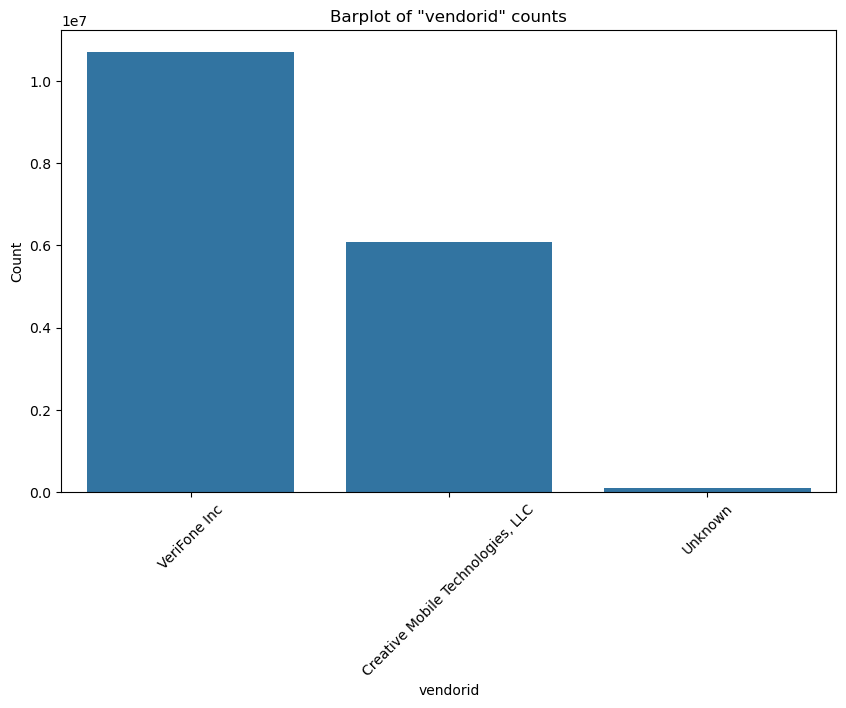

In [16]:
plot_cat_distribution(data=df, column_name="vendorid")

Видно, что в представленном датасете имеется 2 поставщика услуг, а для части поездок поставщик услуг неизвестен.

#### Анализ столбцов `tpep_pickup_datetime` и `tpep_dropoff_datetime`

Посмотрим внимательно на значения в столбце. Видно, что в данных столбцах расположены дата и время начала и окончания поездки.

Определим количество NULL-значений в столбцах.

In [15]:
count_nulls(data=df, column_name="tpep_pickup_datetime")

Число колонок с NULL: 0 (0.00%)


In [16]:
count_nulls(data=df, column_name="tpep_dropoff_datetime")

Число колонок с NULL: 0 (0.00%)


Далее посчитаем переменную trip_duration_seconds (время поездки). Найдём поездки, которые длились более 10 часов.

In [17]:
from pyspark.sql.functions import unix_timestamp

# Вычисляем длительность поездки в секундах
df_with_duration = df.withColumn(
    "trip_duration_seconds", 
    unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")
)

# Находим поездки длительностью более 10 часов 
long_trips = df_with_duration.filter(col("trip_duration_seconds") > 36000)

long_trips_count = long_trips.count()
print(f"Найдено поездок длительностью более 10 часов: {long_trips_count}")

if long_trips_count > 0:
    # Ограничиваем вывод до 10 строк
    show_count = min(long_trips_count, 10)
    
    print(f"\n{show_count} поездок длительностью более 10 часов:")
    
    # Выводим только первые несколько поездок
    long_trips.show(show_count, truncate=False)

Найдено поездок длительностью более 10 часов: 42776

10 поездок длительностью более 10 часов:
+------------+--------------------+---------------------+---------------+-------------+-------------+------------------+------------+-----------+-----+-------+---------------------+----------+--------------------+---------------------+
|vendorid    |tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|ratecodeid   |store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|improvement_surcharge|tip_amount|congestion_surcharge|trip_duration_seconds|
+------------+--------------------+---------------------+---------------+-------------+-------------+------------------+------------+-----------+-----+-------+---------------------+----------+--------------------+---------------------+
|VeriFone Inc|2019-08-30 17:47:34 |2019-08-31 16:58:23  |1              |1.96         |Standard rate|false             |Credit card |10.0       |1.0  |0.5    |0.3                  |2.86      |2.5   

Видим более 40000 поездок, самая длинная поездка длилась 2190071 секунд -  это выброс. Мог сломаться таксометр, водитель мог забыть остановить поездку по каким-то причинам и т.д. Уберем значения для дальнейшего анализа.

In [18]:
df = df.filter(
        unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime") <= 36000
    )

In [19]:
df.count()

16835556

Проверим есть ли отрицательные значения длительности поездки.

In [20]:
negative_duration_trips = df.filter(
    unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime") < 0
)

negative_count = negative_duration_trips.count()
print(f"Найдено поездок с отрицательной длительностью: {negative_count}")
if negative_count > 0:
    # Показываем примеры таких поездок
    negative_duration_trips.show(100, truncate=False)

Найдено поездок с отрицательной длительностью: 196
+---------------------------------+--------------------+---------------------+---------------+-------------+---------------------+------------------+------------+-----------+-----+-------+---------------------+----------+--------------------+
|vendorid                         |tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|ratecodeid           |store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|improvement_surcharge|tip_amount|congestion_surcharge|
+---------------------------------+--------------------+---------------------+---------------+-------------+---------------------+------------------+------------+-----------+-----+-------+---------------------+----------+--------------------+
|Unknown                          |2019-07-18 15:15:10 |2019-07-18 15:15:00  |NULL           |0.0          |NULL                 |NULL              |NULL        |-12.02     |0.0  |-0.5   |-0.3                 |0.0       

Уберем отрицательные значения.

In [21]:
df = df.filter(
        unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime") > 0
    )

In [22]:
df.count()

16820188

#### Анализ столбца `trip_distance`

В соответствии с описанием и содержанием датасета логично считать данный признак **количественным**. Проверим его на наличие пропущенных значений.

In [23]:
count_nulls(data=df, column_name="trip_distance")

Число колонок с NULL: 0 (0.00%)


Видно, что пропуски в данном столбце отсутствуют.

Создадим функцию, позволяющую рассчитывать статистические показатели данных в столбцах и строить диаграмму "ящик с усами" для оценки наличия выбросов.

In [24]:
def plot_boxplots(data: DataFrame,
                  columns: list[str],
                  sample_fraction: float = 0.1) -> None:
    """
    Построение boxplot для нескольких столбцов в PySpark DataFrame.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        columns (list of str): Список имен столбцов для построения boxplot.
        sample_fraction (float): Доля данных для семплирования выбросов.
    
    Returns:
        None
    """
    box_data = []

    for column in columns:
        # Вычисление квантилей
        quantiles = data.approxQuantile(column, [0.25, 0.5, 0.75], 0.01)
        q1, median, q3 = quantiles

        # Вычисление IQR и границ усов
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Фильтрация выбросов
        filtered_df = data.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
        outliers_df = data.filter((col(column) < lower_bound) | (col(column) > upper_bound))

        # Вычисление минимального и максимального значений
        min_value = data.agg({column: "min"}).collect()[0][0]
        mean_value = data.agg({column: "mean"}).collect()[0][0]
        std_value = data.agg({column: "std"}).collect()[0][0]
        max_value = data.agg({column: "max"}).collect()[0][0]

        # Ограничение усов минимальным и максимальным значениями
        lower_bound = max(lower_bound, min_value)
        upper_bound = min(upper_bound, max_value)

        # Семплирование выбросов
        outliers = []
        if not outliers_df.isEmpty():
            sampled_outliers_df = outliers_df.sample(sample_fraction)
            outliers = (
                sampled_outliers_df
                .select(column)
                .limit(1000)
                .collect()
            )
            outliers = [row[column] for row in outliers]
            
            # Добавление минимального и максимального значений, если они 
            # относятся к выбросам и не присутствуют в семпле
            if min_value < lower_bound and min_value not in outliers:
                outliers.append(min_value)
            if max_value > upper_bound and max_value not in outliers:
                outliers.append(max_value)

        # Подготовка данных для axes.bxp
        box_data.append({
            'whislo': lower_bound,  # Нижняя граница усов
            'q1': q1,               # Первый квартиль
            'med': median,          # Медиана
            'q3': q3,               # Третий квартиль
            'whishi': upper_bound,  # Верхняя граница усов
            'fliers': outliers      # Выбросы
        })
        
    # Вывод статистических характеристик
    print(f"Минимальное значение:          {min_value:.2f}")
    print(f"Среднее значение:              {mean_value:.2f}")
    print(f"Среднеквадратичное отклонение: {std_value:.2f}")
    print(f"Первый квартиль:               {q1:.2f}")
    print(f"Медиана:                       {median:.2f}")
    print(f"Третий квартиль:               {q3:.2f}")
    print(f"Максимальное значение:         {max_value:.2f}")

    # Построение boxplot
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.bxp(box_data, 
           vert=False, 
           positions=range(1, len(columns) + 1), widths=0.5)
    ax.set_yticks(range(1, len(columns) + 1))
    ax.set_yticklabels(columns)
    ax.set_xlabel('Value')
    ax.set_title('Boxplots')
    ax.grid(True)
    plt.show()

Минимальное значение:          -30.10
Среднее значение:              3.00
Среднеквадратичное отклонение: 3.93
Первый квартиль:               0.98
Медиана:                       1.63
Третий квартиль:               3.03
Максимальное значение:         830.90


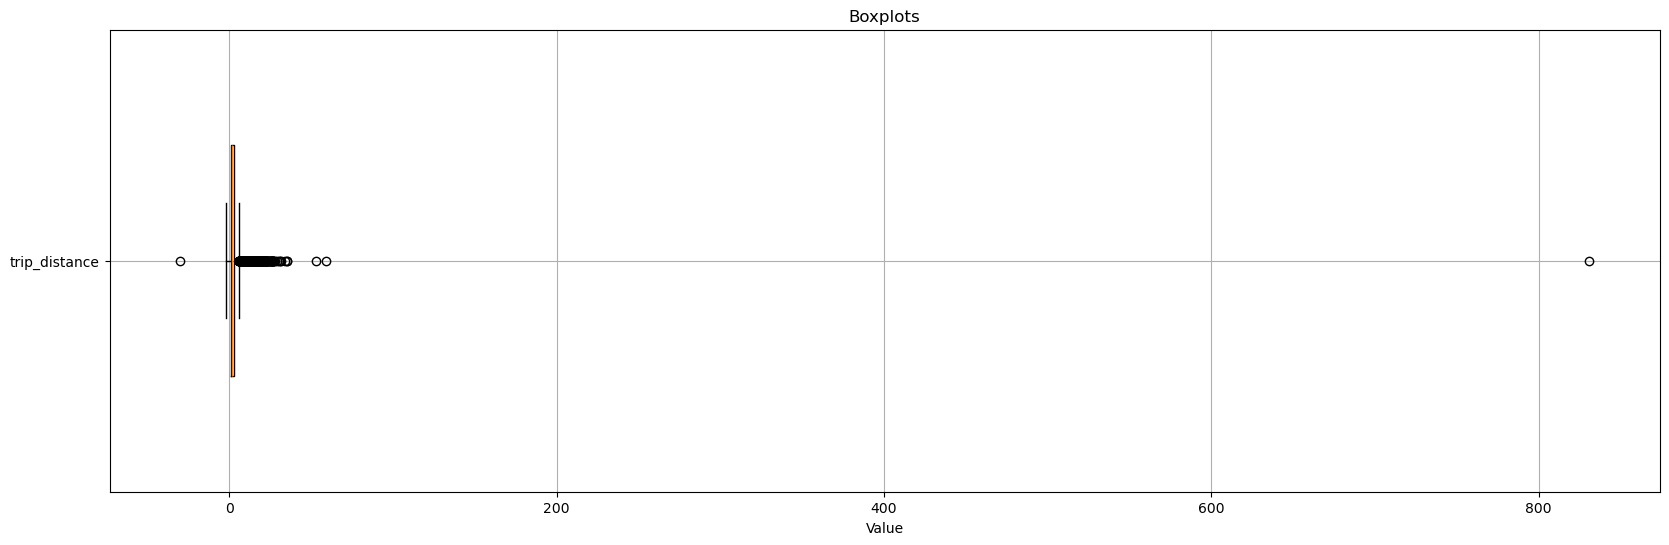

In [25]:
plot_boxplots(data=df, columns=["trip_distance"])

Можно наблюдать сильные выбросы. Удалим строки, их содержащие, и убедимся, что потеряна небольшая часть данных.

In [26]:
df = df.filter((col("trip_distance") >= 0) & (col("trip_distance") < 50))

In [27]:
df.count()

16817375

In [28]:
def plot_quant_distribution(data: DataFrame,
                            column: str,
                            num_bins: int = 200) -> None:
    """
    Построение гистограммы для количественной переменной с 
    использованием PySpark и Seaborn.

    Args:
        data (DataFrame): DataFrame с данными.
        column_name (str): Название колонки с количественной переменной.
        num_bins (int): Количество бинов для гистограммы.

    Returns:
        None
    """
    # Находим минимальное и максимальное значения колонки
    min_value = data.agg({column: "min"}).collect()[0][0]
    max_value = data.agg({column: "max"}).collect()[0][0]

    # Размер бина
    bin_size = (max_value - min_value) / num_bins

    # Добавляем колонку с номером бина
    data = data.withColumn(
        "bin", 
        floor((col(column) - min_value) / bin_size)
    )

    # Группируем по номеру бина и считаем количество строк в каждом бине
    bin_counts = data.groupBy("bin").count()

    # Преобразуем результат в Pandas DataFrame для построения гистограммы
    bin_counts_pd = bin_counts.limit(1000).toPandas()
    
    # Создаем массив границ бинов
    bin_edges = [min_value + i * bin_size for i in range(num_bins + 2)]
    
    # Преобразуем номера бинов в центры бинов
    bin_centers = [
        (bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(num_bins + 1)
    ]
    
    # Добавляем центры бинов в Pandas DataFrame
    bin_counts_pd['bin_center'] = bin_counts_pd['bin'].apply(
        lambda x: bin_centers[int(x)]
    )
    
    # Построение гистограммы с использованием Seaborn
    plt.figure(figsize=(20, 6))
    sns.histplot(data=bin_counts_pd, x="bin_center", 
                 weights="count", kde=True, bins=num_bins + 1)
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.title(f"Распределение количественного признака \"{column}\"")
    plt.grid(True)
    plt.show()

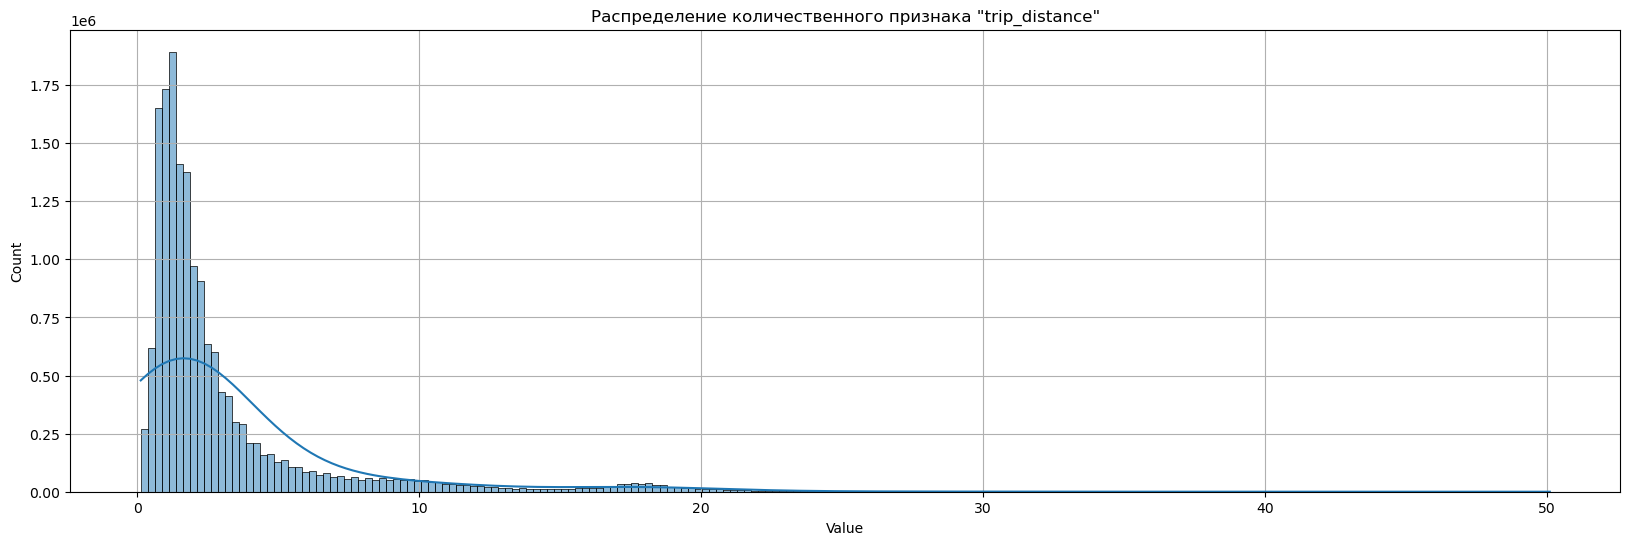

In [29]:
plot_quant_distribution(data=df, column="trip_distance")

In [30]:
df.show()

+--------------------+--------------------+---------------------+---------------+-------------+-------------+------------------+------------+-----------+-----+-------+---------------------+----------+--------------------+
|            vendorid|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|   ratecodeid|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|improvement_surcharge|tip_amount|congestion_surcharge|
+--------------------+--------------------+---------------------+---------------+-------------+-------------+------------------+------------+-----------+-----+-------+---------------------+----------+--------------------+
|        VeriFone Inc| 2019-08-30 18:03:41|  2019-08-30 18:13:08|              1|         2.65|Standard rate|             false| Credit card|       10.5|  1.0|    0.5|                  0.3|       2.0|                 2.5|
|        VeriFone Inc| 2019-08-30 18:02:41|  2019-08-30 18:16:27|              5|         0.69|Standard rate|   

In [31]:
count_nulls(data=df, column_name="passenger_count")

Число колонок с NULL: 47021 (0.28%)


In [32]:
(
    df
    .filter(col("passenger_count").isNotNull())
    .groupBy("passenger_count")
    .count()
    .show()
)

+---------------+--------+
|passenger_count|   count|
+---------------+--------+
|              1|11780318|
|              6|  406204|
|              3|  712589|
|              5|  677185|
|              9|      44|
|              4|  340544|
|              8|      50|
|              7|      77|
|              2| 2548905|
|              0|  304438|
+---------------+--------+



Оставим только те поездки, где количество пассажиров в диапозоне от 1 до 6. Их преобладающее количество.

In [33]:
df = df.filter(col("passenger_count").between(1, 6))
mean_maximum_pass = int(
    df.select(mean(col("passenger_count"))).collect()[0][0]
)
mean_maximum_pass

1

Заменим пропуски средним значением.

In [34]:
df = df.fillna({"passenger_count": mean_maximum_pass})

In [35]:
df.count()

16465745

Количество категорий признака passenger_count: 6


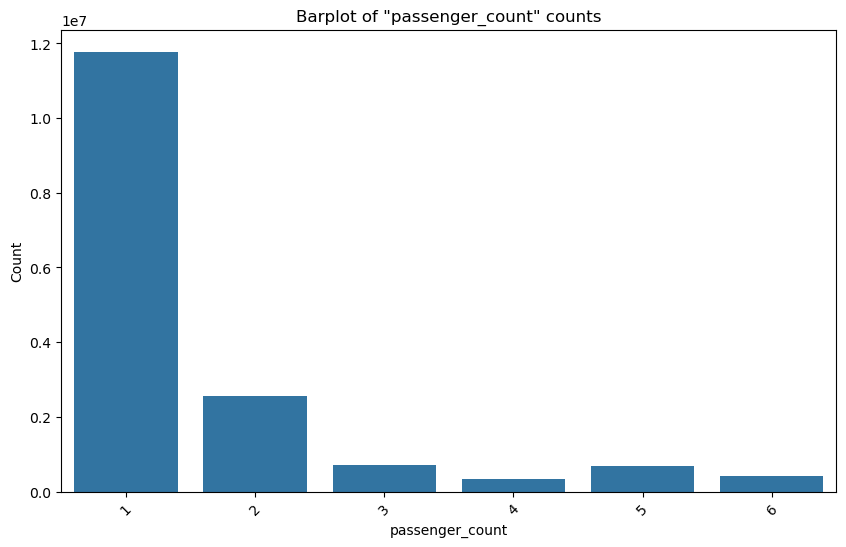

In [36]:
plot_cat_distribution(data=df, column_name="passenger_count")

#### Анализ столбца `ratecodeid`
Признак **категориальный**.

In [37]:
count_nulls(data=df, column_name="ratecodeid")

Число колонок с NULL: 489 (0.00%)


In [38]:
(
    df
    .filter(col("ratecodeid").isNotNull())
    .groupBy("ratecodeid")
    .count()
    .show()
)

+--------------------+--------+
|          ratecodeid|   count|
+--------------------+--------+
|     Negotiated fare|   93019|
|Nassau or Westche...|   12785|
|              Newark|   37190|
|       Standard rate|15884661|
|          Group ride|      95|
|                 JFK|  437506|
+--------------------+--------+



Заменим пропуски модой.

In [39]:
ratecode_mode = (
    df
    .filter(col("ratecodeid").isNotNull())
    .groupBy("ratecodeid")
    .count()
    .orderBy("count", ascending=False)
    .first()[0]
)
ratecode_mode

'Standard rate'

In [40]:
df = df.fillna({"ratecodeid": ratecode_mode})

In [41]:
df.count()

16465745

Количество категорий признака ratecodeid: 6


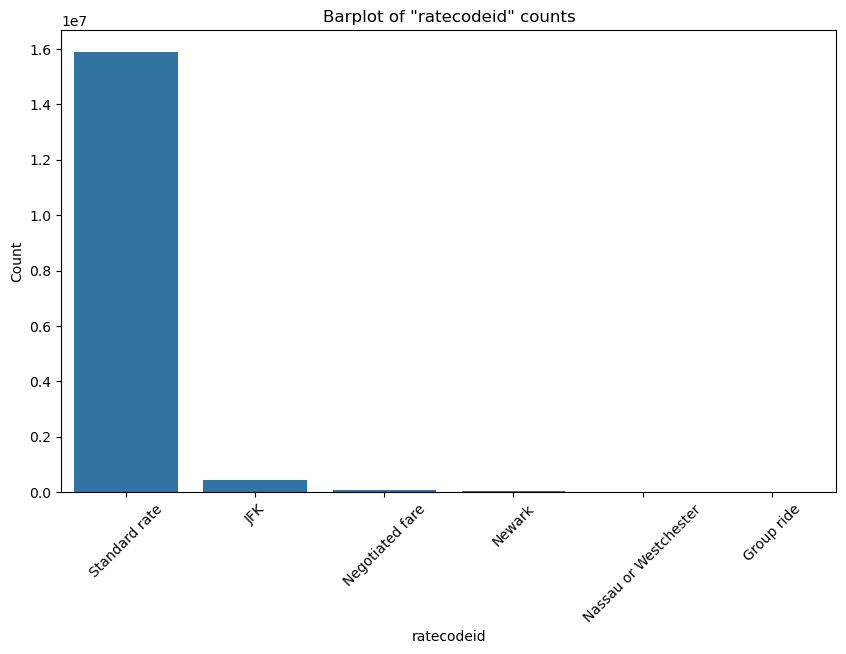

In [42]:
plot_cat_distribution(data=df, column_name="ratecodeid")

In [43]:
df.show()

+--------------------+--------------------+---------------------+---------------+-------------+-------------+------------------+------------+-----------+-----+-------+---------------------+----------+--------------------+
|            vendorid|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|   ratecodeid|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|improvement_surcharge|tip_amount|congestion_surcharge|
+--------------------+--------------------+---------------------+---------------+-------------+-------------+------------------+------------+-----------+-----+-------+---------------------+----------+--------------------+
|        VeriFone Inc| 2019-08-30 18:03:41|  2019-08-30 18:13:08|              1|         2.65|Standard rate|             false| Credit card|       10.5|  1.0|    0.5|                  0.3|       2.0|                 2.5|
|        VeriFone Inc| 2019-08-30 18:02:41|  2019-08-30 18:16:27|              5|         0.69|Standard rate|   

#### Анализ столбца `store_and_fwd_flag`

Данный признак является **бинарным**.

In [44]:
count_nulls(data=df, column_name="store_and_fwd_flag")

Число колонок с NULL: 0 (0.00%)


Пропуски отсутствуют.

Количество категорий признака store_and_fwd_flag: 2


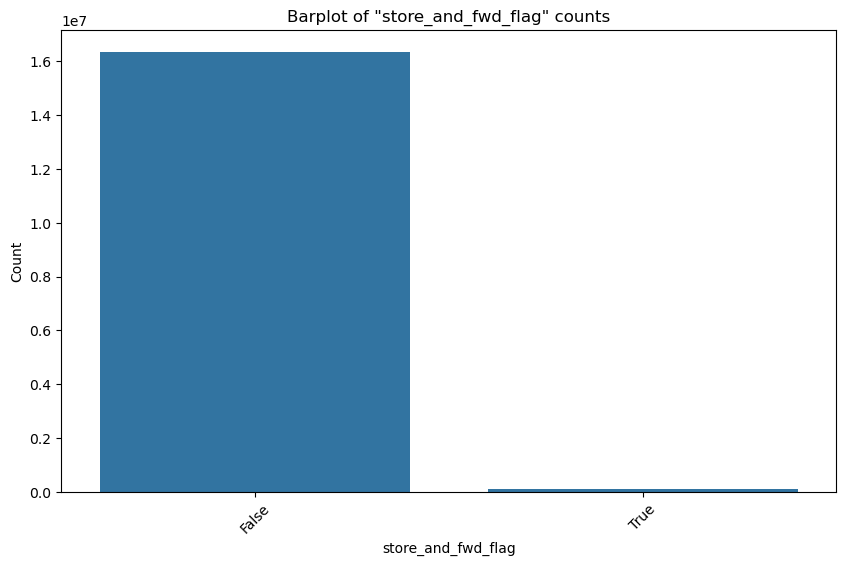

In [45]:
plot_cat_distribution(data=df, column_name="store_and_fwd_flag")

In [46]:
df.show()

+--------------------+--------------------+---------------------+---------------+-------------+-------------+------------------+------------+-----------+-----+-------+---------------------+----------+--------------------+
|            vendorid|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|   ratecodeid|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|improvement_surcharge|tip_amount|congestion_surcharge|
+--------------------+--------------------+---------------------+---------------+-------------+-------------+------------------+------------+-----------+-----+-------+---------------------+----------+--------------------+
|        VeriFone Inc| 2019-08-30 18:03:41|  2019-08-30 18:13:08|              1|         2.65|Standard rate|             false| Credit card|       10.5|  1.0|    0.5|                  0.3|       2.0|                 2.5|
|        VeriFone Inc| 2019-08-30 18:02:41|  2019-08-30 18:16:27|              5|         0.69|Standard rate|   

#### Анализ признака `payment_type`
Признак **категориальный**.

In [47]:
count_nulls(data=df, column_name="payment_type")

Число колонок с NULL: 0 (0.00%)


Пропусков нет.

In [48]:
(
    df
    .filter(col("payment_type").isNotNull())
    .groupBy("payment_type")
    .count()
    .show()
)

+------------+--------+
|payment_type|   count|
+------------+--------+
|        Cash| 4473706|
|     Dispute|   35156|
|   No charge|   83970|
| Credit card|11872912|
|     Unknown|       1|
+------------+--------+



Количество категорий признака payment_type: 5


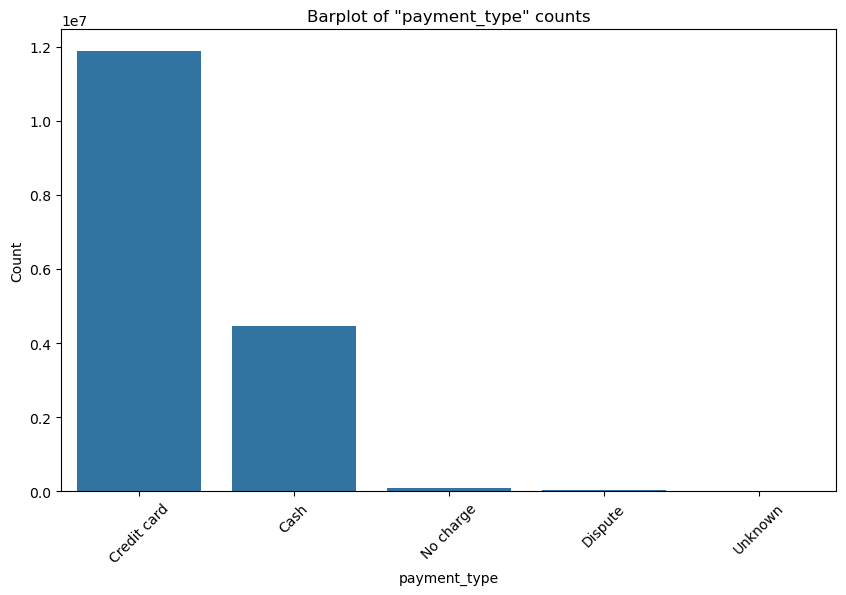

In [49]:
plot_cat_distribution(data=df, column_name="payment_type")

#### Анализ признака `fare_amount`
Признак **количественный**.

In [50]:
count_nulls(data=df, column_name="fare_amount")

Число колонок с NULL: 0 (0.00%)


Видно, что пропуски в данном столбце отсутствуют.

Минимальное значение:          -600.00
Среднее значение:              13.22
Среднеквадратичное отклонение: 102.00
Первый квартиль:               6.50
Медиана:                       9.50
Третий квартиль:               15.00
Максимальное значение:         411042.01


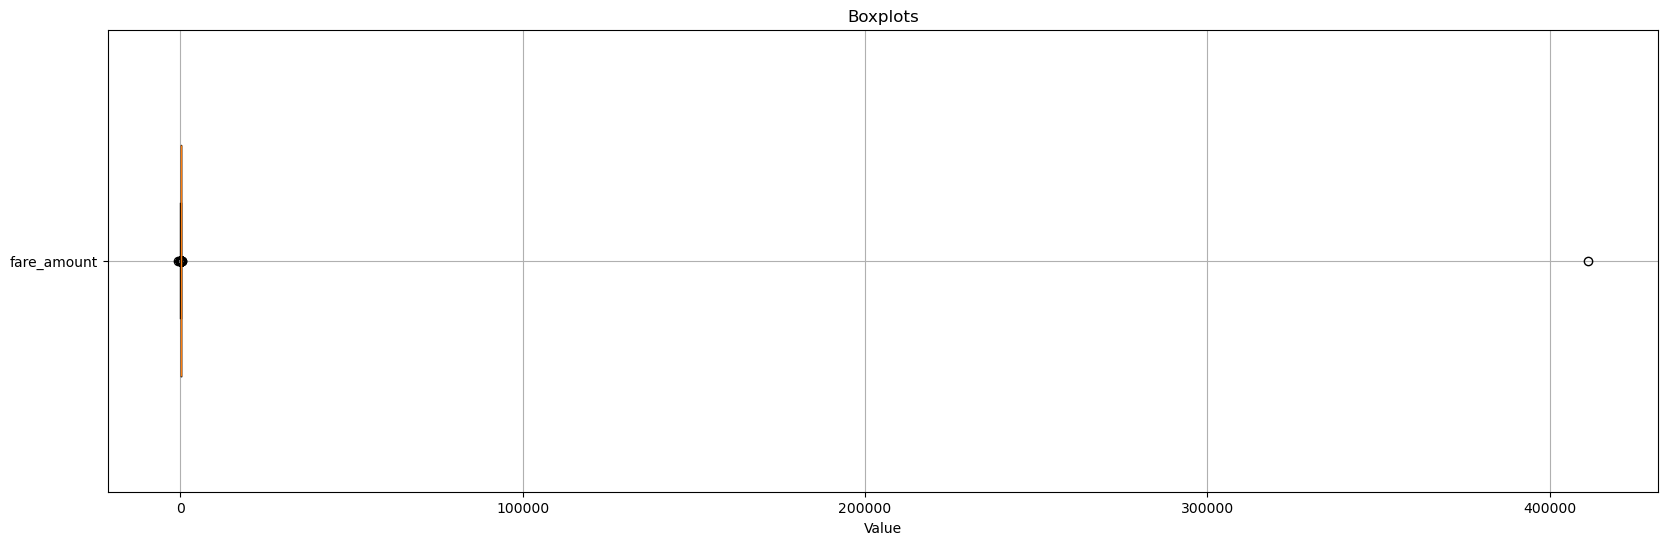

In [51]:
plot_boxplots(data=df, columns=["fare_amount"])

Видим очень большой выброс, исправим.

In [52]:
df = df.filter((col("fare_amount") >= 0) & (col("fare_amount") <= 50))

In [53]:
df.count()

15827756

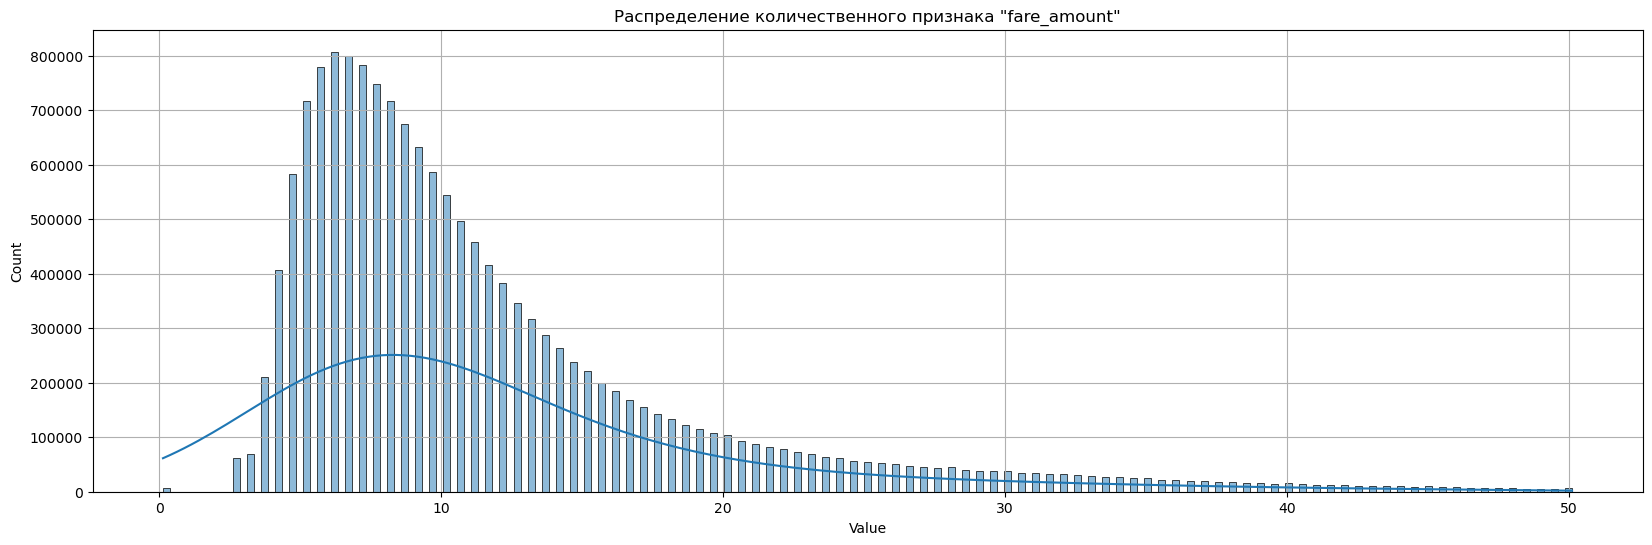

In [54]:
plot_quant_distribution(data=df, column="fare_amount")

In [55]:
df.show()

+--------------------+--------------------+---------------------+---------------+-------------+-------------+------------------+------------+-----------+-----+-------+---------------------+----------+--------------------+
|            vendorid|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|   ratecodeid|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|improvement_surcharge|tip_amount|congestion_surcharge|
+--------------------+--------------------+---------------------+---------------+-------------+-------------+------------------+------------+-----------+-----+-------+---------------------+----------+--------------------+
|        VeriFone Inc| 2019-08-30 18:03:41|  2019-08-30 18:13:08|              1|         2.65|Standard rate|             false| Credit card|       10.5|  1.0|    0.5|                  0.3|       2.0|                 2.5|
|        VeriFone Inc| 2019-08-30 18:02:41|  2019-08-30 18:16:27|              5|         0.69|Standard rate|   

#### Анализ признака `extra`
Признак **количественный**.

In [56]:
count_nulls(data=df, column_name="extra")

Число колонок с NULL: 0 (0.00%)


Пропуски в данном столбце отсутствуют.

Минимальное значение:          -26.50
Среднее значение:              1.06
Среднеквадратичное отклонение: 1.20
Первый квартиль:               0.00
Медиана:                       0.50
Третий квартиль:               2.50
Максимальное значение:         27.60


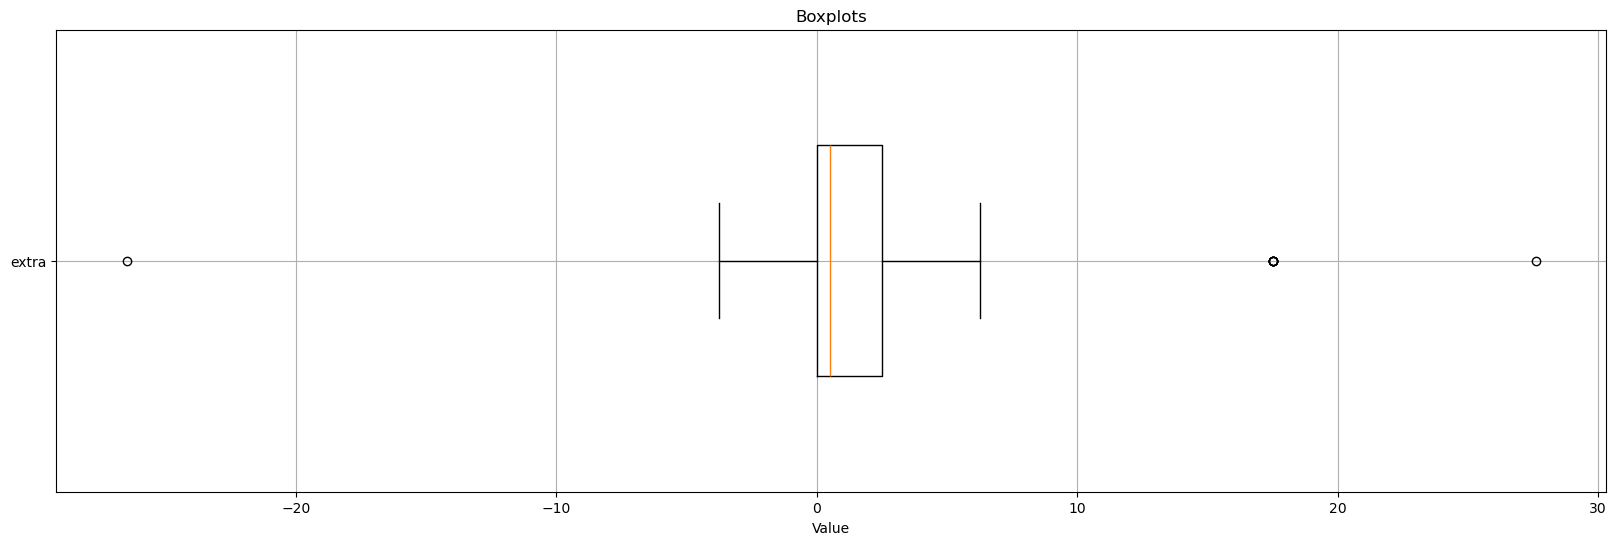

In [57]:
plot_boxplots(data=df, columns=["extra"])

По условию в данный столбец записываются значения о дополнительной плате (0.5 доллара за поездку в час пик и 1 за ночную поездку). Остальные значения кроме нуля являются выбросом, удалим их.

In [58]:
(
    df
    .filter(col("extra").isNotNull())
    .groupBy("extra")
    .count()
    .show()
)

+-----+-------+
|extra|  count|
+-----+-------+
|  0.0|5899709|
|  3.5| 829702|
|  2.5|2458732|
|  1.0|1895459|
| 17.5|     38|
| 18.5|      5|
|  0.8|    734|
|  2.8|      6|
|  0.5|3377986|
|  1.3|    412|
|  4.3|      1|
|  3.0|1364506|
| -0.5|      1|
|  1.8|    218|
|  0.3|     24|
|  5.5|     18|
| 12.0|      1|
| -1.2|     26|
| -1.7|     61|
| 18.0|      6|
+-----+-------+
only showing top 20 rows



In [59]:
df = df.filter((col("extra") == 0.5) | (col("extra") == 0.0) | (col("extra") == 1.0))

In [60]:
df.count()

11173154

Количество категорий признака extra: 3


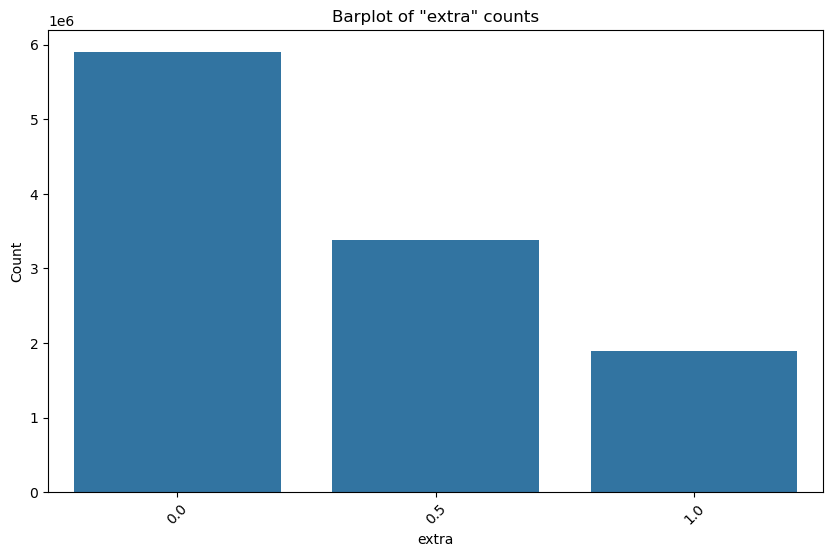

In [61]:
plot_cat_distribution(data=df, column_name="extra")

#### Анализ признака `mta_tax`
Признак **количественный**.

In [62]:
count_nulls(data=df, column_name="mta_tax")

Число колонок с NULL: 0 (0.00%)


Пропуски в данном столбце отсутствуют.

In [63]:
(
    df
    .filter(col("mta_tax").isNotNull())
    .groupBy("mta_tax")
    .count()
    .show()
)

+-------+--------+
|mta_tax|   count|
+-------+--------+
|    0.0|   31240|
|   0.87|       7|
|    0.5|11141862|
|    3.3|       1|
|   1.44|       5|
|   0.25|      35|
|   2.78|       1|
|    0.9|       2|
|   2.77|       1|
+-------+--------+



В данный столбец записываются значения об оплате налога 0.5 доллара за поездку. Остальные значения кроме нуля являются выбросом, удалим их.

In [64]:
df = df.filter((col("mta_tax") == 0.5) | (col("mta_tax") == 0.0))

In [65]:
df.count()

11173102

Количество категорий признака mta_tax: 2


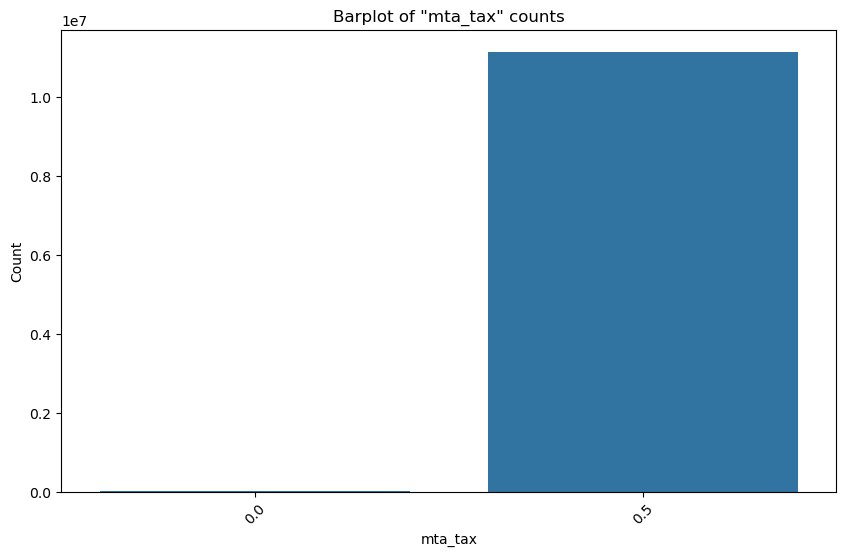

In [66]:
plot_cat_distribution(data=df, column_name="mta_tax")

#### Анализ признака `improvement_surcharge`
Признак **количественный**.

In [67]:
count_nulls(data=df, column_name="improvement_surcharge")

Число колонок с NULL: 0 (0.00%)


Пропуски в данном столбце отсутствуют.

In [68]:
(
    df
    .filter(col("improvement_surcharge").isNotNull())
    .groupBy("improvement_surcharge")
    .count()
    .show()
)

+---------------------+--------+
|improvement_surcharge|   count|
+---------------------+--------+
|                  0.0|    3837|
|                  0.3|11169264|
|                  1.0|       1|
+---------------------+--------+



В данный столбец записываются значения о доплате 0.3 доллара за благоустройство такси. Остальные значения кроме нуля являются выбросом, удалим их.

In [69]:
df = df.filter((col("improvement_surcharge") == 0.3) | (col("improvement_surcharge") == 0.0))

Количество категорий признака improvement_surcharge: 2


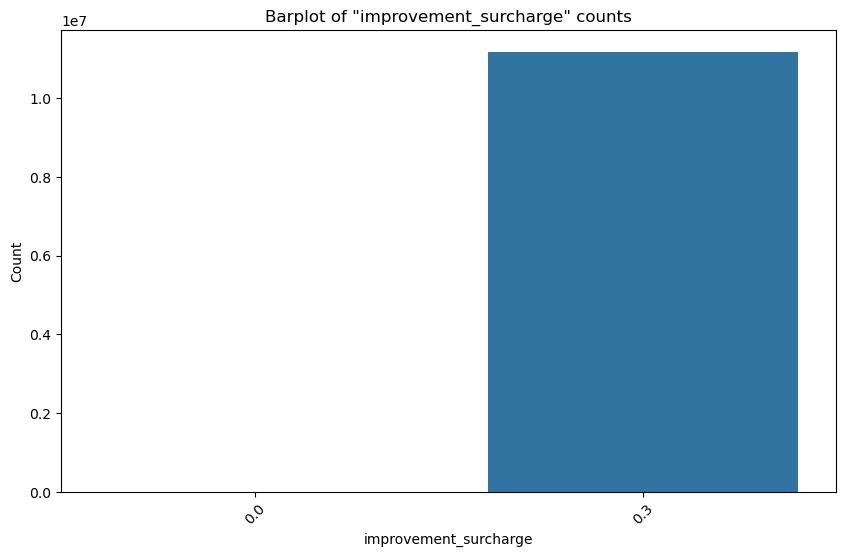

In [70]:
plot_cat_distribution(data=df, column_name="improvement_surcharge")

In [71]:
df.count()

11173101

In [72]:
df.show()

+--------------------+--------------------+---------------------+---------------+-------------+-------------+------------------+------------+-----------+-----+-------+---------------------+----------+--------------------+
|            vendorid|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|   ratecodeid|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|improvement_surcharge|tip_amount|congestion_surcharge|
+--------------------+--------------------+---------------------+---------------+-------------+-------------+------------------+------------+-----------+-----+-------+---------------------+----------+--------------------+
|        VeriFone Inc| 2019-08-30 18:03:41|  2019-08-30 18:13:08|              1|         2.65|Standard rate|             false| Credit card|       10.5|  1.0|    0.5|                  0.3|       2.0|                 2.5|
|        VeriFone Inc| 2019-08-30 18:02:41|  2019-08-30 18:16:27|              5|         0.69|Standard rate|   

#### Анализ признака `tip_amount`

Признак **количественный**. Чаевые в данном столбце записываются только когда оплата прошла по кредитной карте.

In [73]:
count_nulls(data=df, column_name="tip_amount")

Число колонок с NULL: 0 (0.00%)


Пропуски в данном столбце отсутствуют.

In [74]:
(
    df
    .filter(col("tip_amount").isNotNull())
    .filter(col("payment_type") != "Credit card")
    .groupBy("tip_amount", "payment_type")  
    .count()
    .show(10, truncate=False)
)

+----------+------------+-----+
|tip_amount|payment_type|count|
+----------+------------+-----+
|1.96      |Cash        |7    |
|3.32      |Cash        |1    |
|0.98      |Cash        |1    |
|1.25      |Cash        |3    |
|0.06      |No charge   |4    |
|0.93      |Cash        |1    |
|5.95      |Cash        |3    |
|1.27      |Cash        |1    |
|0.83      |No charge   |1    |
|1.02      |Dispute     |1    |
+----------+------------+-----+
only showing top 10 rows



Видно, что чаевые взымались не только по кредитной карте, отфильтруем строки.

In [75]:
df = df.filter(
    (col("tip_amount") == 0) | (col("payment_type") == "Credit card")
)

Минимальное значение:          0.00
Среднее значение:              1.96
Среднеквадратичное отклонение: 2.28
Первый квартиль:               0.00
Медиана:                       1.80
Третий квартиль:               2.86
Максимальное значение:         638.00


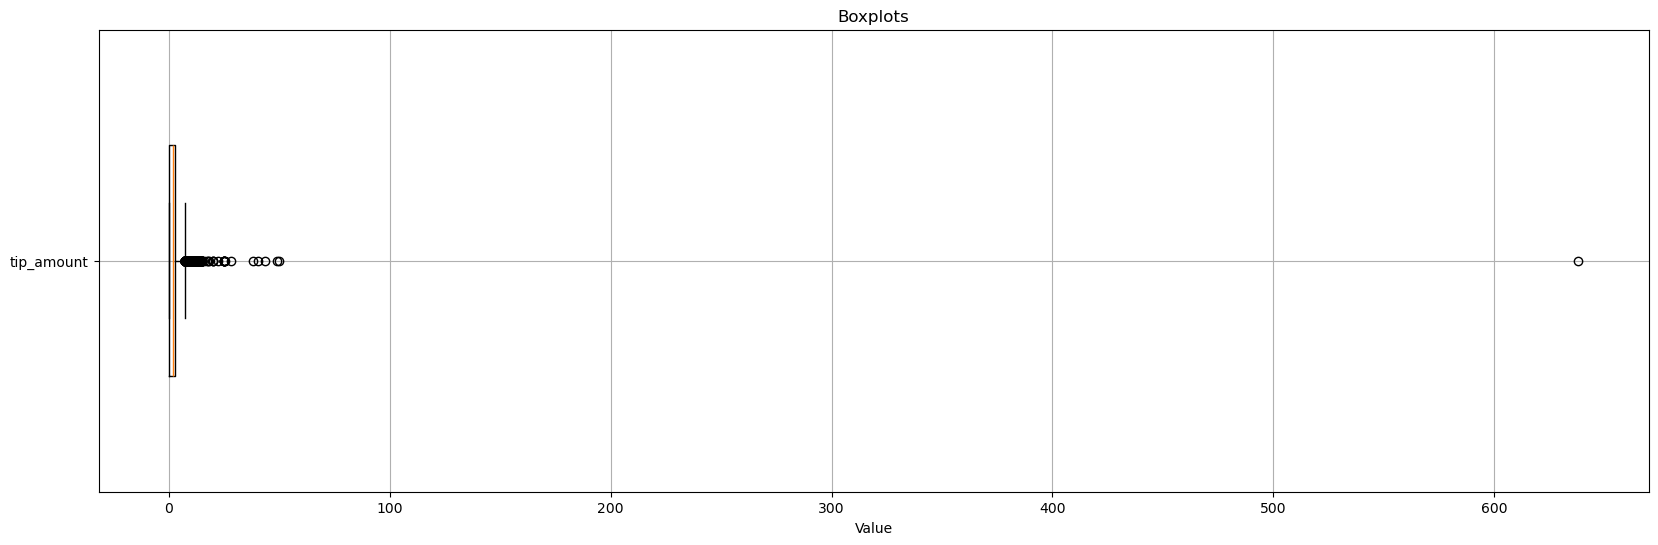

In [76]:
plot_boxplots(data=df, columns=["tip_amount"])

Видим выбросы, исправим.

In [77]:
df = df.filter((col("tip_amount") <= 10) & (col("tip_amount") >= 0))

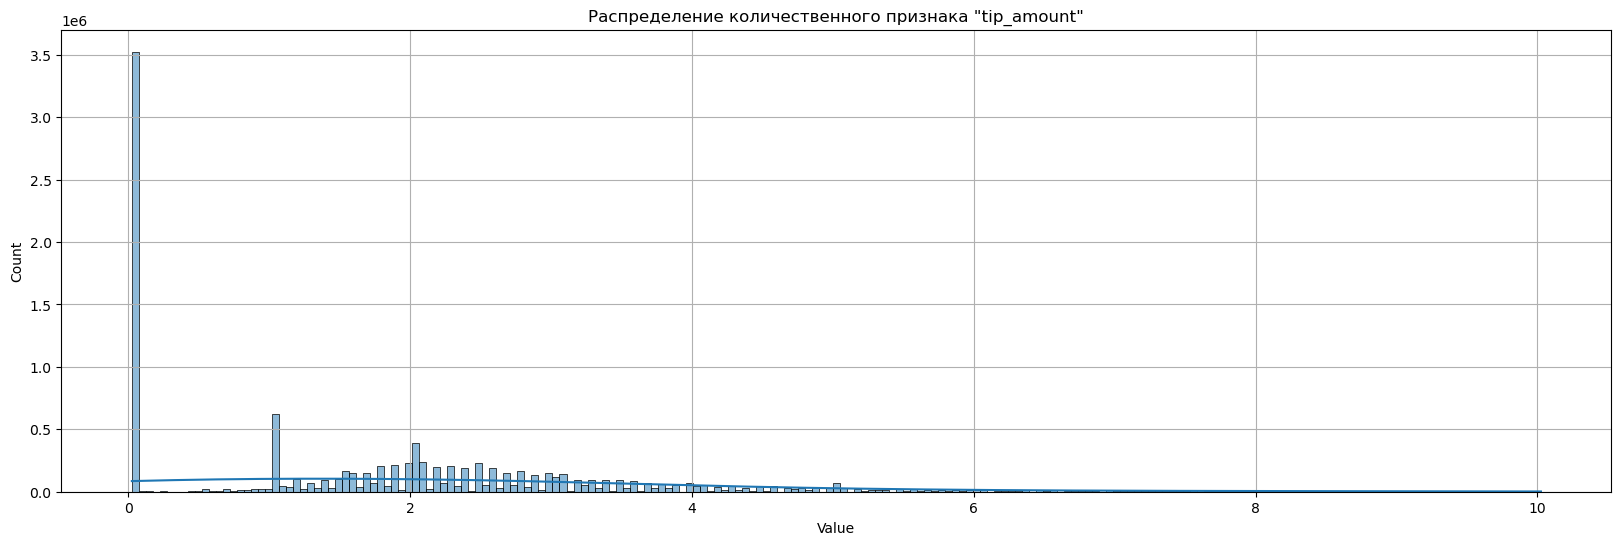

In [78]:
plot_quant_distribution(data=df, column="tip_amount")

#### Анализ столбца `congestion_surcharge`

Признак **количественный**. Признак обозначает надбавку к стоимости поездки на такси, которая применяется к поездкам, начинающимся, заканчивающимся или проходящим через определённые районы в определённые периоды. Для такси 2.5 доллара США.

In [79]:
count_nulls(data=df, column_name="congestion_surcharge")

Число колонок с NULL: 918996 (8.28%)


In [80]:
(
    df
    .filter(col("congestion_surcharge").isNotNull())
    .groupBy("congestion_surcharge")
    .count()
    .show()
)

+--------------------+-------+
|congestion_surcharge|  count|
+--------------------+-------+
|                 0.0|1613805|
|                 2.5|8559341|
|                 0.5|      1|
|                0.75|    227|
|                2.75|    210|
|                 3.0|      1|
+--------------------+-------+



In [81]:
df = df.filter((col("congestion_surcharge") == 0.0) | (col("congestion_surcharge") == 2.5))

Количество категорий признака congestion_surcharge: 2


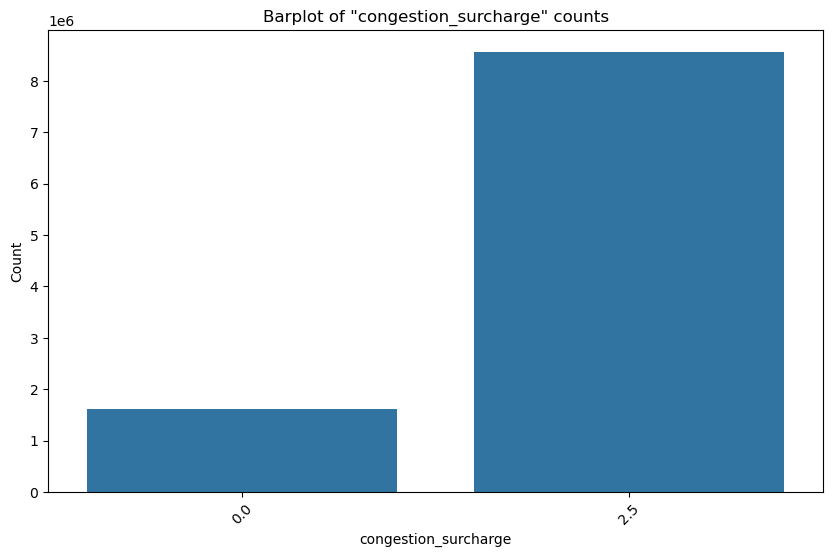

In [82]:
plot_cat_distribution(data=df, column_name="congestion_surcharge")

In [83]:
df.count()

10173146

#### Расчет корреляции между количественными признаками

In [84]:
def compute_and_visualize_correlation_matrix(data: DataFrame, 
                                             columns: list[str]) -> None:
    """
    Вычисляет и визуализирует корреляционную матрицу для указанных 
    колонок в DataFrame PySpark.

    Args:
        df (DataFrame): DataFrame PySpark.
        columns (list[str]): Список колонок для вычисления корреляции.

    Returns:
        None
    """
    # Вычисление корреляционной матрицы
    corr_matrix = {}
    for col1 in columns:
        corr_matrix[col1] = {}
        for col2 in columns:
            corr_value = data.select(corr(col1, col2)).collect()[0][0]
            corr_matrix[col1][col2] = corr_value

    # Преобразование корреляционной матрицы в DataFrame Pandas для визуализации
    corr_matrix_pd = pd.DataFrame(corr_matrix)

    # Построение и визуализация корреляционной матрицы
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix_pd, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

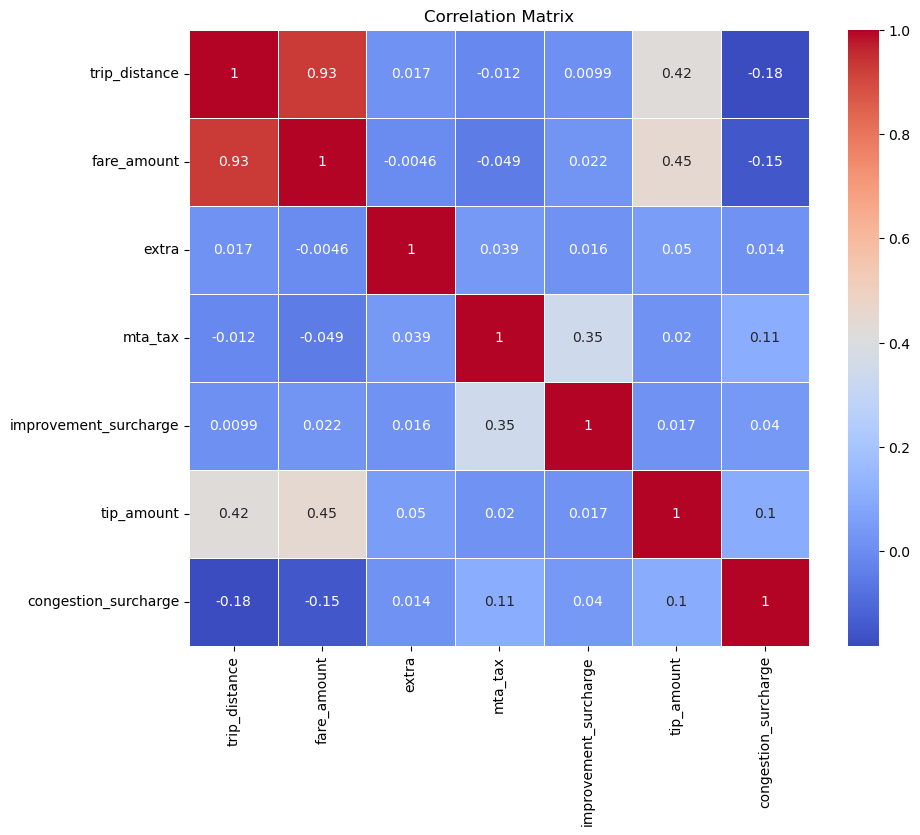

In [85]:
compute_and_visualize_correlation_matrix(
    data=df, columns=[
        "trip_distance", "fare_amount", "extra",
        "mta_tax", "improvement_surcharge", "tip_amount", 
        "congestion_surcharge"
    ]
)

Корреляционная матрица демонстрирует наличие корреляции между некоторыми количественными признаками.

In [86]:
df.show()

+--------------------+--------------------+---------------------+---------------+-------------+-------------+------------------+------------+-----------+-----+-------+---------------------+----------+--------------------+
|            vendorid|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|   ratecodeid|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|improvement_surcharge|tip_amount|congestion_surcharge|
+--------------------+--------------------+---------------------+---------------+-------------+-------------+------------------+------------+-----------+-----+-------+---------------------+----------+--------------------+
|        VeriFone Inc| 2019-08-30 18:03:41|  2019-08-30 18:13:08|              1|         2.65|Standard rate|             false| Credit card|       10.5|  1.0|    0.5|                  0.3|       2.0|                 2.5|
|        VeriFone Inc| 2019-08-30 18:02:41|  2019-08-30 18:16:27|              5|         0.69|Standard rate|   

Посмотрим, сколько объектов осталось после преобразований датасета.

In [87]:
df.count()

10173146

In [88]:
df.printSchema()

root
 |-- vendorid: string (nullable = false)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = false)
 |-- trip_distance: double (nullable = true)
 |-- ratecodeid: string (nullable = false)
 |-- store_and_fwd_flag: boolean (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)



In [89]:
df.write.parquet("/home/user/work/csvtaxi/taxibuild3.parquet")

Останавливаем `Spark`-сессию.

In [90]:
spark.stop()